# Livabiltiy and affordability

This notebook is to define livability and affordability scores, and make predictions on the top 10 suburbs in Victoria based on the scores

#### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import folium

/Users/sunnywu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### read the files

In [2]:
# Read the file for rent prices
rent = pd.read_csv("../data/curated/final_drop_pcg.csv")

In [3]:
###### Read crime rate 
crime_rate = pd.read_csv("../data/curated/crime_rate.csv")

### Join with the crime data

In [4]:
# select the relevant columns
crime_rate = crime_rate[['SAL_CODE', 'crime_rate']]

In [5]:
crime_rate

,SAL_CODE,crime_rate
0,20002,0.227735
1,20003,0.054822
2,20011,0.044528
3,20013,0.011613
4,20015,0.254085
...,...,...
748,22916,0.005469
749,22917,0.124611
750,22919,0.096439
751,22924,0.074300


In [6]:
# join rent and crime rate 
rent = rent.merge(crime_rate, left_on='SAL_CODE', right_on='SAL_CODE', how='left')

In [7]:
rent.columns

Index(['Location', 'type_property', 'price', 'state', 'rooms', 'bath',
       'parking', 'link', 'public_1', 'public_1_dis', 'public_2',
       'public_2_dis', 'private_1', 'private_1_dis', 'pulic_1_dis',
       'pulic_2_dis', 'rent', 'is_furnished', 'latitude', 'longitude',
       'geometry', 'SA2_NAME', 'SA2_CODE', 'SAL_NAME21', 'SAL_CODE',
       'Immediate Family', 'Extended Family', 'Total Suburb Population',
       'Two persons in family', 'Three persons in family',
       'Four persons in family', 'Five persons in family',
       'Six or more persons in family', 'Separate house',
       'Semi-detached house or Townhouse', 'Flat or Apartment',
       'Non-residential properties', 'Total Suburb Dwellings', 'coordinate',
       'distance_to_melbourne_cbd_km', 'nearest_shopping_center_distance_km',
       'nearest_tram_station_distance_km', 'nearest_train_station_distance_km',
       'nearest_bus_stop_distance_km', 'nearest_school_distance_km',
       'crime_rate'],
      dtype='obj

## Define livability score and affordability score

In [8]:
# calculate livability without crime and affordability as defined
rent['liveability'] = 5/(rent['nearest_shopping_center_distance_km'] + rent['nearest_tram_station_distance_km'] + rent['nearest_train_station_distance_km'] + rent['nearest_bus_stop_distance_km'] + rent['nearest_school_distance_km'])
rent['affordability'] = 1/(rent['rent']/(rent['rooms'] + 0.5 * rent['bath'] + 0.3 * rent['parking']))

In [9]:
# select the relevant columns for visualisation
rent = rent[['SAL_NAME21', 'crime_rate', 'liveability', 'affordability']]

If a suburb has less than 5 listings, we won't consider the livability of that suburb since 1. It's hard for renters to rent a property in that suburb given the limited demand and the calculated livability/affordability could be very bias to a single property or two and does not reflect the actual renting conditions of that suburb

In [10]:
# the most livable suburbs that have more than 5 listings available
rent_afford = rent.groupby('SAL_NAME21').median().loc[rent.groupby('SAL_NAME21').count()['liveability']>=5][['crime_rate', 'liveability', 'affordability']]

In [11]:
# scale crime rate
rent_afford['crime_rate_scaled'] = (rent_afford['crime_rate']-rent_afford['crime_rate'].min())/(rent_afford['crime_rate'].max()-rent_afford['crime_rate'].min()) + 1

In [12]:
# scale livability and affordability and adding crime to livability
rent_afford['liveability_scaled'] = ((rent_afford['liveability'] - rent_afford['liveability'].min())/(rent_afford['liveability'].max()-rent_afford['liveability'].min()))/np.power(rent_afford['crime_rate_scaled'], 0.5) + 1 
rent_afford['affordability_scaled'] = (rent_afford['affordability'] - rent_afford['affordability'].min())/(rent_afford['affordability'].max()-rent_afford['affordability'].min()) + 1

In [13]:
# the rmsq sum of livability and affordability to combine the two
rent_afford['combine'] = np.sqrt(1.6*(rent_afford['liveability_scaled'])**2 + (rent_afford['affordability_scaled'])**2)
rent_afford['combine'] = (rent_afford['combine']-rent_afford['combine'].min())/(rent_afford['combine'].max()-rent_afford['combine'].min()) + 1
rent_afford.sort_values('combine', ascending=False)[0:10]

,crime_rate,liveability,affordability,crime_rate_scaled,liveability_scaled,affordability_scaled,combine
SAL_NAME21,,,,,,,
Kingsbury,0.054822,0.816727,0.012400,1.031983,1.209878,1.964000,2.000000
Prahran,0.054822,2.784739,0.004308,1.031983,1.720291,1.073846,1.910944
South Yarra,0.353561,3.093931,0.004012,1.246455,1.728365,1.041341,1.903921
Melbourne,1.403177,3.803004,0.003704,2.000000,1.707107,1.007407,1.849342
Box Hill (Vic.),0.054822,2.430719,0.005357,1.031983,1.628474,1.189286,1.843395
Delacombe,0.054822,0.047273,0.012727,1.031983,1.010316,2.000000,1.836200
Winter Valley,0.033052,0.044843,0.012444,1.016354,1.009760,1.968889,1.798861
Smythes Creek,0.054822,0.044276,0.012444,1.031983,1.009539,1.968889,1.798646
Footscray,0.054822,2.255064,0.005625,1.031983,1.582917,1.218750,1.794795


In [14]:
afford_top10 = rent_afford.sort_values('combine', ascending=False)[0:10]

In [15]:
afford_top10 = afford_top10.sort_values('combine', ascending=True)

In [16]:
afford_top10 = afford_top10[['liveability_scaled', 'affordability_scaled', 'combine']]

### Visualisation

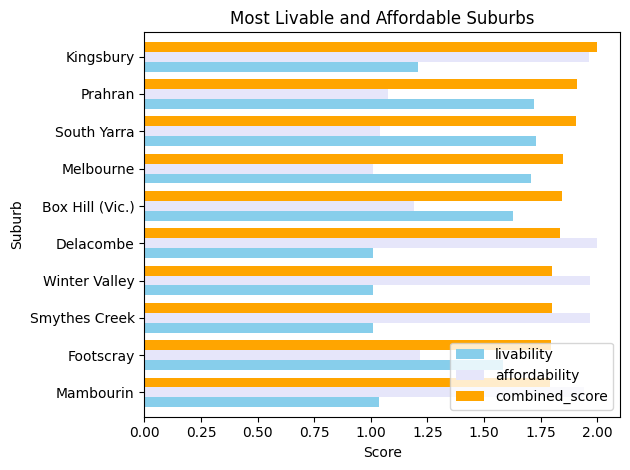

In [17]:
# visualisation
afford_top10.plot(kind='barh', width=0.8, color = ['skyblue','lavender','orange'])  

plt.title('Most Livable and Affordable Suburbs')
plt.ylabel('Suburb')
plt.xlabel('Score')
plt.tight_layout()
plt.legend(['livability','affordability','combined_score'], loc = 'lower right')
plt.savefig('../plots/most_livable_and_affordable_suburbs')
plt.show()

# Geovisualisation

In [18]:
# Path to the SAL files
SAL_file_path = '../data/landing/SAL_2021_AUST_GDA2020_SHP/SAL_2021_AUST_GDA2020.shp'
# Read the GeoPandas DataFrame from the specified file
SAL_region_gdf = gpd.read_file(SAL_file_path)

In [19]:
# Select the relevant states
SAL_region_gdf = SAL_region_gdf.loc[SAL_region_gdf['STE_NAME21']=='Victoria']

In [20]:
# create a JSON object about location and their respective geomtry
geoJSON = SAL_region_gdf[['SAL_NAME21', 'geometry']].to_json()

## Top 10 livable subrubs

In [21]:
# most livable suburbs
top10_livable = rent_afford.sort_values('liveability_scaled', ascending=False)[0:10]

In [22]:
# get the geo for top 10 
top10_livable = pd.merge(top10_livable, SAL_region_gdf, on = 'SAL_NAME21', how = 'inner')

In [23]:
# get the centroid for each suburb for visualisation
top10_livable['centroid'] = top10_livable['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))

In [24]:
# plot the map for most livable
m1 = folium.Map(location=[-37.8136, 144.9631], tiles="Stamen Terrain", zoom_start=10)

folium.Choropleth(
    geo_data=geoJSON,
    name='top 10 suburbs',
    fill_color='yellow',
).add_to(m1)

# add the label for top suburbs
for zone_name, coord in top10_livable[['SAL_NAME21', 'centroid']].values:
    folium.Marker(
        location=coord, 
        tooltip=folium.Tooltip(zone_name, permanent=True, direction="right")
    ).add_to(m1)
m1.save('../plots/livable_geo.html')

## TOP 10 affordable suburbs

In [25]:
# most affordable suburbs
top10_affordable = rent_afford.sort_values('affordability_scaled', ascending=False)[0:10]

In [26]:
# get the geo for top 10 
top10_affordable = pd.merge(top10_affordable, SAL_region_gdf, on = 'SAL_NAME21', how = 'inner')

In [27]:
# get the centroid for each suburb for visualisation
top10_affordable['centroid'] = top10_affordable['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))

In [28]:
# plot the map for most affordable
m1 = folium.Map(location=[-37.8136, 144.9631], tiles="Stamen Terrain", zoom_start=10)

folium.Choropleth(
    geo_data=geoJSON,
    name='top 10 suburbs',
    fill_color='yellow',
).add_to(m1)

# add the label for top suburbs
for zone_name, coord in top10_affordable[['SAL_NAME21', 'centroid']].values:
    folium.Marker(
        location=coord, 
        tooltip=folium.Tooltip(zone_name, permanent=True, direction="below")
    ).add_to(m1)
m1.save('../plots/affordable_geo.html')

## Combined

In [29]:
# most livable suburbs
top10_combine = rent_afford.sort_values('combine', ascending=False)[0:10]

In [30]:
# get the geo for top 10 
top10_combine = pd.merge(top10_combine, SAL_region_gdf, on = 'SAL_NAME21', how = 'inner')

In [31]:
# get the centroid for each suburb for visualisation
top10_combine['centroid'] = top10_combine['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))

In [32]:
# plot the map for highest combine score
m1 = folium.Map(location=[-37.8136, 144.9631], tiles="Stamen Terrain", zoom_start=10)

folium.Choropleth(
    geo_data=geoJSON,
    name='top 10 suburbs',
    fill_color='yellow',
).add_to(m1)

# add the label for top suburbs
for zone_name, coord in top10_combine[['SAL_NAME21', 'centroid']].values:
    folium.Marker(
        location=coord, 
        tooltip=folium.Tooltip(zone_name, permanent=True, direction="below")
    ).add_to(m1)
m1.save('../plots/affordable_geo.html')